# Logan Clark - College To NFL Trends (QB)

Predicting a players NFL Fantasy Football success by using College Football stats along with Random Forest Regression, and Neural Network Regression. 

**Data**

Evaluation Methodology: The current value metric I am using for each player is

Value = (QB1 Years/Years Played) + (Years Played/20)

My logic behind this is that it tries to mix how well a player performs by year along with their longevity.


Source: Pahowdy's Database

https://docs.google.com/spreadsheets/d/1D1D9rXo3BXX867qBju77VjZ9YIoAp-nXYFqSGDQgajU/edit#gid=224755041











In [1]:
!pip install tensorflow-addons

import math
import time

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa

import torch

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics

tf.keras.backend.set_floatx('float64')

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

from helper_functions import create_tensorboard_callback, plot_loss_curves

     |████████████████████████████████| 1.1 MB 2.6 MB/s 
--2021-11-02 22:44:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-02 22:44:21 (84.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
def eval_model(model, X_test, y_test, hist):
    print("eval", model.evaluate(X_test, y_test))
    print("predict", model.predict(X_test[:10]))
    pd.DataFrame(hist.history).plot()
    plt.ylabel("loss")
    plt.xlabel("epochs")

metrics = [tf.metrics.mae, tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))]
    

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Prep

In [65]:
data = pd.read_csv('/content/gdrive/My Drive/pahowdy_cfb_qb_training.csv')
rookie_data = pd.read_csv('/content/gdrive/My Drive/pahowdy_cfb_qb_rookies.csv')

features = (data.columns)[4:39]

print(features)

print(data.head())
print(rookie_data.head())

data = data.to_numpy()
rookie_data = rookie_data.to_numpy()
rookie_names = rookie_data[:,0]

#data = np.delete(data, 0, axis=0)
#rookie_data = np.delete(rookie_data, 0, axis=0)

print(data.shape)
print(rookie_data.shape)



Index(['Conference', 'DR', 'DP', 'Last year designation', 'Age IN DRAFT YEAR',
       'Conference Drafted Rate', 'Conference Hit Rate',
       'Age Draft Hit Rate AVG', 'Rush ATT/Game', 'Pass Attempts',
       'Completions', 'Comp %', 'All Yards', 'Years played', 'G',
       'COMP% (Last Year)', 'Pass Yard Per Game (Last)', 'QB AVG YP(PassA)',
       'QB AVG AY/A',
       'CPOE* (*hacked versions - adjusted by PaYds/G instead of aDot- COMP% over expected using conference AVG since 2003)',
       'Comp AVG', 'AVG PassRat', 'AVG TANYA', 'BMI', 'weight', 'height', '40',
       '3Cone', 'shuttle', 'vert', 'broadInches', 'Burst Score', 'HaSS',
       'WaSS', '# of top 5  finishes'],
      dtype='object')
             Name            cfb_id  ... Years Played Longevity Score
0      Drew Brees      drew-brees-1  ...           20        1.750000
1   Philip Rivers   philip-rivers-1  ...           17        1.497059
2   Aaron Rodgers   aaron-rodgers-1  ...           16        1.487500
3  Russell 

In [66]:
def encode_cfb_data(input_data):
  ConferenceDict = {'ACC':0, 'ACC (Atlantic)':1, 'ACC (Coastal)':2, 'American':3, 'American (East)':4, 'American (West)':5,
                  'Big 12':6, 'Big 12 (North)':7, 'Big 12 (South)':8, 'Big East':9, 'Big Ten':10, 'Big Ten (East)':11,
                  'Big Ten (Leaders)':12, 'Big Ten (Legends)':13, 'Big Ten (West)':14, 'CUSA': 15, 'CUSA (East)':16,
                  'CUSA (West)':17, 'Ind':18, 'MAC (East)':19, 'MAC (West)':20, 'MWC':21, 'MWC (Mountain)':22,
                  'MWC (West)':23, 'Pac-10':24, 'Pac-12 (North)':25, 'Pac-12 (South)':26, 'SEC (East)':27,
                  'SEC (West)':28, 'Sun Belt':29, 'Sun Belt (East)':30, 'Sun Belt (West)':31, 'WAC':31, 'Big West':32}

  DraftRoundDict = {'UDFA':9}

  DraftPositionDict = {'UDFA':260}

  LastYearDesignationDict = {'SR':3, 'JR':2, 'SO':1, 'FR':0}

  for player in input_data:
    player[4] = ConferenceDict[(player[4].replace("\xa0", " "))]

    if player[5] in DraftRoundDict:
      player[5] = DraftRoundDict[player[5]]
    if player[6] in DraftPositionDict:
      player[6] = DraftPositionDict[player[6]]
    if player[7] in LastYearDesignationDict:
      player[7] = LastYearDesignationDict[player[7]]

  return input_data

In [67]:
# Data Encoding
data = encode_cfb_data(data)

rookie_data = encode_cfb_data(rookie_data)

In [68]:
# Split data into X and y

X = list()
y = list()

X_rookie = list()

for player in data:
  X.append(player[4:38])
  y.append(player[45])

for player in rookie_data:
  X_rookie.append(player[4:38])

310

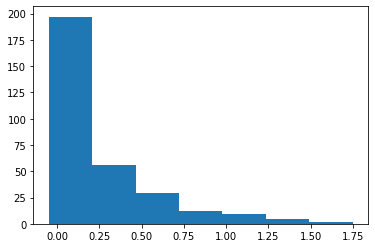

In [69]:
# Check distribution
plt.hist(y, bins=7)
len(y)

In [70]:
# Oversample because data is so unbalanced, and good qbs are more important than bad ones
# Adding only 52 samples from the top qbs improved random forest by 30%

for i in range(len(y)):
  if y[i] > 0.75:
    X.append(X[i])
    X.append(X[i])

    y.append(y[i])
    y.append(y[i])

362

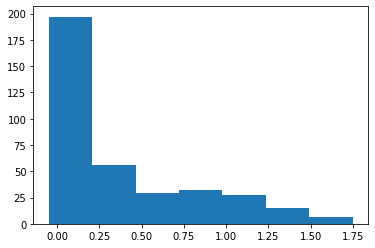

In [71]:
plt.hist(y, bins=7)
len(y)

In [72]:
# Convert to numpy arrays

X = np.array(X).astype(float) 
y = np.array(y).astype(float)

X_rookie = np.array(X_rookie).astype(float)

In [73]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [87]:
for i in X_train:
  print(i)

tf.Tensor(
[2.4000e+01 7.0000e+00 2.2300e+02 3.0000e+00 2.3000e+01 1.6000e-02
 0.0000e+00 1.6000e-01 5.9000e+00 1.4510e+03 8.4800e+02 5.8400e-01
 1.1011e+04 4.0000e+00 4.2000e+01 6.0600e-01 7.6000e+00 7.4000e+00
 8.4400e+00 3.2000e-02 5.7200e-01 9.9800e+01 6.1000e+00 2.7090e+01
 2.1100e+02 7.4000e+01 4.9600e+00 7.2200e+00 4.1900e+00 2.8000e+01
 1.1200e+02 1.0360e+02 7.0550e+01 6.9720e+01], shape=(34,), dtype=float64)
tf.Tensor(
[ 1.0000e+00  1.0000e+00  3.2000e+01  2.0000e+00  2.1000e+01  1.2700e-01
  1.7600e-01  5.5600e-01  1.7200e+01  1.0860e+03  6.1900e+02  5.7000e-01
  1.3175e+04  3.0000e+00  3.8000e+01  5.9100e-01  8.5000e+00  8.2000e+00
  9.4400e+00 -6.0000e-03  5.6700e-01  9.5900e+01  8.1000e+00  2.7730e+01
  2.1600e+02  7.4000e+01  3.7000e+00  4.2000e+00  2.5900e+00  2.0000e+01
  7.1700e+01  1.0760e+02  8.8580e+01  8.5000e+01], shape=(34,), dtype=float64)
tf.Tensor(
[2.8000e+01 1.0000e+01 3.0000e+02 3.0000e+00 2.3000e+01 1.1100e-01
 8.0000e-02 9.0000e-03 1.0100e+01 1.1860e+03 7

# Baseline Random Forest Model

In [74]:
rfReg = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf_r_squared = rfReg.score(X_test, y_test)
rf_r_squared

0.7614108689196637

In [75]:
#List features by importance

feature_importance = rfReg.feature_importances_

feature_numbered_list = list()
for i in range(len(feature_importance)):
  feature_numbered_list.append((feature_importance[i], features[i]))


sorted_features = sorted(feature_numbered_list, reverse=True)
for i in sorted_features:
  print(i)

(0.49277027883265095, 'DP')
(0.053515556712407056, 'CPOE* (*hacked versions - adjusted by PaYds/G instead of aDot- COMP% over expected using conference AVG since 2003)')
(0.03620096718358376, '3Cone')
(0.03186614948759143, 'Pass Attempts')
(0.02654951248990172, 'AVG PassRat')
(0.02041962517529213, 'Comp %')
(0.02037795702123998, 'Comp AVG')
(0.018818958207899156, 'Rush ATT/Game')
(0.01846710543060071, 'Conference')
(0.018199654334457003, 'Conference Hit Rate')
(0.01786626165221567, 'Pass Yard Per Game (Last)')
(0.017656987408466687, 'QB AVG YP(PassA)')
(0.01656890580481467, 'All Yards')
(0.014792252527382782, 'broadInches')
(0.014789415009642105, 'Age Draft Hit Rate AVG')
(0.01438491301197563, 'Conference Drafted Rate')
(0.014271853891754054, 'weight')
(0.013573308407748827, 'QB AVG AY/A')
(0.012847029969883144, 'shuttle')
(0.011454967934726168, 'height')
(0.011303965485920877, 'HaSS')
(0.01098592695462685, 'Completions')
(0.010971837476867665, 'BMI')
(0.010049601204848099, 'AVG TANYA'

# Baseline Neural Network

In [76]:
tf.keras.backend.clear_session

<function keras.backend.clear_session>

In [77]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Pre-processing layer (normalization)
data_normalization = Sequential([
                                 preprocessing.Normalization()
], name="data_normalization")

# Setup input shape
input_shape = 34

# Assemble model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_normalization(inputs)
x = layers.Dense(64)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(8)(x)
x = layers.LeakyReLU()(x)
outputs = layers.Dense(1, name="output_layer")(x)
model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metrics)

history_0 = model_0.fit(X_train, y_train, epochs=50, callbacks=[create_tensorboard_callback(dir_name="qb_trends",
                                                                                            experiment_name="model_0")])

Saving TensorBoard log files to: qb_trends/model_0/20211102-231440
Epoch 1/50
10/10 [==============================] - 1s 19ms/step - loss: 736.6243 - mean_absolute_error: 736.6243 - r_square: -3265262.2500
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 213.6577 - mean_absolute_error: 213.6577 - r_square: -280170.0625
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 96.4707 - mean_absolute_error: 96.4707 - r_square: -70041.5234
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 55.2642 - mean_absolute_error: 55.2642 - r_square: -21042.7969
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 55.1437 - mean_absolute_error: 55.1437 - r_square: -24361.1562
Epoch 6/50
10/10 [==============================] - 0s 3ms/step - loss: 37.0251 - mean_absolute_error: 37.0251 - r_square: -10900.9258
Epoch 7/50
10/10 [==============================] - 0s 3ms/step - loss: 29.7902 - mean_absolute_error: 29.7902 - r_

In [78]:
model_0.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 21.2119 - mean_absolute_error: 21.2119 - r_square: -2562.1155


[21.211938492239337, 21.211939241505704, -2562.115478515625]

# Model 1, Deep Model

In [79]:
model_1 = tf.keras.Sequential([
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(10),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(1),
])

model_1.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=metrics)

history = model_1.fit(X_train, y_train, epochs=50)

Epoch 1/50
10/10 [==============================] - 1s 4ms/step - loss: 136.8195 - mean_absolute_error: 136.8195 - r_square: -126880.0312
Epoch 2/50
10/10 [==============================] - 0s 4ms/step - loss: 15.4979 - mean_absolute_error: 15.4979 - r_square: -3156.3840
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 12.6615 - mean_absolute_error: 12.6615 - r_square: -1409.7714
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 22.5313 - mean_absolute_error: 22.5313 - r_square: -3790.1350
Epoch 5/50
10/10 [==============================] - 0s 6ms/step - loss: 7.8961 - mean_absolute_error: 7.8961 - r_square: -523.8484
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 6.8383 - mean_absolute_error: 6.8383 - r_square: -382.9559
Epoch 7/50
10/10 [==============================] - 0s 4ms/step - loss: 5.5684 - mean_absolute_error: 5.5684 - r_square: -275.6421
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - l

In [80]:
model_1.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.7934 - mean_absolute_error: 0.7934 - r_square: -2.8682


[0.793437171472262, 0.7934371901741087, -2.868178367614746]

# Predicting with Top 2 Models

In [83]:
def normalized_predictions_with_names(predictions):
  pred_sum = sum(predictions)

  normalized_preds = [(float(i)/pred_sum)*1000 for i in predictions]

  names_preds = dict()

  for i in range(len(normalized_preds)):
      if type(normalized_preds[i]) is np.ndarray:
        names_preds[rookie_names[i]] = normalized_preds[i][0]
      else:
        names_preds[rookie_names[i]] = normalized_preds[i]   
          
  sorted_rookies = sorted(names_preds.items(), key=lambda x: x[1], reverse=True)

  # for i in sorted_rookies:
  #     print(i)
  return sorted_rookies

def sort_predictions_with_names(predictions):
  names_preds = dict()

  for i in range(len(predictions)):
      if type(predictions[i]) is np.ndarray:
        names_preds[rookie_names[i]] = predictions[i][0]
      else:
        names_preds[rookie_names[i]] = predictions[i]   
          
  sorted_rookies = sorted(names_preds.items(), key=lambda x: x[1], reverse=True)


  return sorted_rookies

In [84]:
rf_preds = rfReg.predict(X_rookie)
rf_preds_sorted = sort_predictions_with_names(rf_preds)
rf_preds_norm = normalized_predictions_with_names(rf_preds)

for i in rf_preds_sorted:
  print(i)

('Trevor Lawrence', 0.7242125260190001)
('Justin Fields', 0.6541341036850002)
('Zach Wilson', 0.6235759804300002)
('Davis Mills', 0.5452090964660001)
('Mac Jones', 0.5351687406100002)
('Kellen Mond', 0.3745400237010001)
('Dustin Crum', 0.3115000000000001)
('Matt Corral', 0.24550000000000008)
('Kyle Trask', 0.22529551820800017)
('Ian Book', 0.20383333334199996)
('Sam Ehlinger', 0.19349999999999998)
('Hunter Johnson', 0.17442857142600002)
('Myles Brennan', 0.125)
('K.J. Costello', 0.11628571428399972)
('Phil Jurkovec', 0.10799999999999998)
('Jamie Newman', 0.10799999999999989)
('Joe Milton', 0.10249999999999998)
('JT Daniels', 0.09149999999999993)
('Michael Penix Jr.', 0.07550000000000004)
('Brock Purdy', 0.06350000000000007)
('Dorian Thompson-Robinson', 0.04650000000000005)
('Adrian Martinez', 0.04350000000000004)
('McKenzie Milton', 0.03900000000000002)
('Sam Hartman', 0.030722222222000023)
('Shane Buechele', 0.03050000000000004)
('Peyton Ramsey', 0.030500000000000017)
('Josh Jackson',

In [86]:
model_1_preds = model_1.predict(X_rookie)
model_1_preds_sorted = sort_predictions_with_names(model_1_preds)
model_1_preds_norm = normalized_predictions_with_names(model_1.predict(X_rookie))

for i in model_1_preds_sorted:
  print(i)

('Kellen Mond', 1.6642705933555901)
('Trevor Lawrence', 1.6513867726628415)
('Sam Ehlinger', 1.6274299727402461)
('Ian Book', 1.3375957021043399)
('Zach Wilson', 1.2145793627641897)
('Shane Buechele', 1.1995103100999351)
('McKenzie Milton', 1.1486372987820137)
("D'Eriq King", 1.1381817887178307)
("J'mar Smith", 1.1236266225038178)
('Brock Purdy', 1.0666393826518608)
('Justin Fields', 1.0613590109796678)
('Kyle Trask', 0.977114744415119)
('Mac Jones', 0.8762195161651627)
('Peyton Ramsey', 0.7899538088526606)
('Jake Bentley', 0.779988594576055)
('Adrian Martinez', 0.7236390241041327)
('Matt Corral', 0.6203491929935532)
('Dustin Crum', 0.6059885495710077)
('K.J. Costello', 0.5904795325334283)
('Dorian Thompson-Robinson', 0.48578854101282165)
('Jarrett Guarantano', 0.4719994502885397)
('Davis Mills', 0.46438318994983374)
('Jamie Newman', 0.44659118338577014)
('Sam Hartman', 0.4131887185135783)
('Josh Jackson', 0.38457849890932394)
('JT Daniels', 0.2849803111161254)
('Quinten Dormady', 0.27

## Model Comparison

```
The random forest model lines up much more with expert rankings, especially at the top, but 
it's also a much safer model with it's best qb prediction being a 0.72 (equivalent to the 30th best in training).
While the neural network seems much riskier with it's top 3 qb predictions being ~1.6 (equivalent to the 2nd best in training).
```

# Training with Data that does not involve Draft Position to search for "Sleepers"

Theory: Players that's value increases the most when the data does not involve draft position are talented players who were not drafted high meaning they would have a higher % chance to breakout than the average player at their draft position.

In [88]:
# Split data into X and y, while removing features that are draft position or are related

X_sleeper = list()
y_sleeper = list()

X_sleeper_rookie = list()

for player in data:
  temp1 = player[7:14]
  temp2 = player[16:38]
  X_sleeper.append(list(temp1)+list(temp2))
  y_sleeper.append(player[45])

for player in rookie_data:
  temp1 = player[7:14]
  temp2 = player[16:38]
  X_sleeper_rookie.append(list(temp1)+list(temp2))

X_sleeper = np.array(X_sleeper).astype(float) 
y_sleeper = np.array(y_sleeper).astype(float)

X_sleeper_rookie = np.array(X_sleeper_rookie).astype(float)

In [89]:
# Split data into train and test
X_train_sleeper, X_test_sleeper, y_train_sleeper, y_test_sleeper = train_test_split(X_sleeper, y_sleeper, test_size=0.2, random_state=1)

X_train_sleeper = tf.convert_to_tensor(X_train_sleeper)
X_test_sleeper = tf.convert_to_tensor(X_test_sleeper)
y_train_sleeper = tf.convert_to_tensor(y_train_sleeper)
y_test_sleeper = tf.convert_to_tensor(y_test_sleeper)

In [90]:
#Train Random Forest
rf_sleeper = RandomForestRegressor(n_estimators=100).fit(X_train_sleeper, y_train_sleeper)
rf_r_squared_sleeper = rf_sleeper.score(X_test_sleeper, y_test_sleeper)
rf_r_squared_sleeper

0.40194692253324205

In [91]:
#List features by importance

sleeper_features = features[3:]

feature_importance = rf_sleeper.feature_importances_

feature_numbered_list = list()
for i in range(len(feature_importance)):
  feature_numbered_list.append((feature_importance[i], sleeper_features[i]))


sorted_features = sorted(feature_numbered_list, reverse=True)
for i in sorted_features:
  print(i)

(0.3340878978400667, 'Age Draft Hit Rate AVG')
(0.0639574545141997, 'QB AVG YP(PassA)')
(0.04624275732491729, 'QB AVG AY/A')
(0.04268449760834706, 'Pass Attempts')
(0.038251976789666964, 'CPOE* (*hacked versions - adjusted by PaYds/G instead of aDot- COMP% over expected using conference AVG since 2003)')
(0.031753304096905764, 'Years played')
(0.031419909300875064, 'Rush ATT/Game')
(0.03139499179031466, 'AVG TANYA')
(0.025649494801778357, 'All Yards')
(0.023915664616548666, 'AVG PassRat')
(0.02376584297402206, 'Completions')
(0.0237632626841799, 'broadInches')
(0.021673088550414592, 'BMI')
(0.021226768902748685, 'G')
(0.020988841205773486, 'vert')
(0.02025965038858948, 'COMP% (Last Year)')
(0.019358092090999948, '40')
(0.01927275989034661, 'Conference Hit Rate')
(0.01896283956523567, 'shuttle')
(0.01859057326515451, 'Pass Yard Per Game (Last)')
(0.017328214216993935, 'height')
(0.017114575341880718, '3Cone')
(0.016385580541862142, 'Burst Score')
(0.016249605961479514, 'Conference Draft

In [92]:
# Retrain model_1 on new data
model_1_sleeper = tf.keras.Sequential([
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(10),
                            tf.keras.layers.LeakyReLU(),
                            tf.keras.layers.Dense(1),
])

model_1_sleeper.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=metrics)

history = model_1_sleeper.fit(X_train_sleeper, y_train_sleeper, epochs=50)

Epoch 1/50
8/8 [==============================] - 1s 5ms/step - loss: 134.2128 - mean_absolute_error: 134.2128 - r_square: -178515.2344
Epoch 2/50
8/8 [==============================] - 0s 5ms/step - loss: 40.5056 - mean_absolute_error: 40.5056 - r_square: -19819.7012
Epoch 3/50
8/8 [==============================] - 0s 5ms/step - loss: 7.2691 - mean_absolute_error: 7.2691 - r_square: -752.3097
Epoch 4/50
8/8 [==============================] - 0s 5ms/step - loss: 4.7964 - mean_absolute_error: 4.7964 - r_square: -319.8689
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 5.7129 - mean_absolute_error: 5.7129 - r_square: -511.7383
Epoch 6/50
8/8 [==============================] - 0s 5ms/step - loss: 5.0970 - mean_absolute_error: 5.0970 - r_square: -327.1938
Epoch 7/50
8/8 [==============================] - 0s 7ms/step - loss: 4.4972 - mean_absolute_error: 4.4972 - r_square: -303.1363
Epoch 8/50
8/8 [==============================] - 0s 5ms/step - loss: 2.9204 - mean_ab

In [93]:
model_1_sleeper.evaluate(X_test_sleeper, y_test_sleeper)

2/2 [==============================] - 0s 11ms/step - loss: 0.3860 - mean_absolute_error: 0.3860 - r_square: -0.6202


[0.38601833678060965, 0.3860183223524796, -0.620232105255127]

In [98]:
rf_preds_sleeper = rf_sleeper.predict(X_sleeper_rookie)
rf_preds_sorted_sleeper = sort_predictions_with_names(rf_preds_sleeper)
rf_preds_norm_sleeper = normalized_predictions_with_names(rf_sleeper.predict(X_sleeper_rookie))

for i in rf_preds_sorted_sleeper:
  print(i)


('Zach Wilson', 0.759054271774)
('Mac Jones', 0.7432125979060001)
('Justin Fields', 0.5966347770140001)
('Trevor Lawrence', 0.49805217086500014)
('Davis Mills', 0.46997347913400006)
('Ian Book', 0.33038888889800005)
('Dustin Crum', 0.30300000000000016)
('Kyle Trask', 0.3017895658230001)
('Kellen Mond', 0.295333333333)
('K.J. Costello', 0.25392857142399994)
('Myles Brennan', 0.18999999999999997)
('Phil Jurkovec', 0.18449999999999997)
('Hunter Johnson', 0.15685714285599991)
('JT Daniels', 0.15649999999999994)
('Matt Corral', 0.1509999999999999)
('Michael Penix Jr.', 0.14276984127399997)
('Joe Milton', 0.13049999999999998)
('Shane Buechele', 0.12849999999999986)
('Sam Ehlinger', 0.11494444444399993)
('Jamie Newman', 0.100722222222)
('Brock Purdy', 0.08305555555999992)
('McKenzie Milton', 0.06550000000000007)
('Quinten Dormady', 0.059500000000000025)
('Josh Jackson', 0.04171428571400002)
('Peyton Ramsey', 0.03850000000000004)
('Dorian Thompson-Robinson', 0.03250000000000001)
("D'Eriq King"

In [100]:
model_1_preds_sleeper = model_1_sleeper.predict(X_sleeper_rookie)
model_1_preds_sorted_sleeper = sort_predictions_with_names(model_1_preds_sleeper)
model_1_preds_norm_sleeper = normalized_predictions_with_names(model_1_sleeper.predict(X_sleeper_rookie))

for i in model_1_preds_sorted_sleeper:
  print(i)

('Sam Ehlinger', 0.8593694253144336)
('Shane Buechele', 0.8073464703883008)
('Kellen Mond', 0.6810534312742161)
('Trevor Lawrence', 0.6517191170892735)
('Ian Book', 0.6505213811238323)
('Hunter Johnson', 0.6436196078466434)
("J'mar Smith", 0.6329807749565984)
('Peyton Ramsey', 0.555524754926502)
('Brock Purdy', 0.5551232258078117)
('McKenzie Milton', 0.5454996415513452)
('Jake Bentley', 0.4968932920914676)
("D'Eriq King", 0.48450920722119406)
('K.J. Costello', 0.4383379759080217)
('Zach Wilson', 0.40975009022231296)
('Jarrett Guarantano', 0.3957679342238226)
('Kyle Trask', 0.3802748257929531)
('Dorian Thompson-Robinson', 0.37504218669721817)
('Jamie Newman', 0.3153822691110674)
('Joe Milton', 0.31105851317925615)
('Sam Hartman', 0.30025120208202477)
('Josh Jackson', 0.29763336382190586)
('Adrian Martinez', 0.2966099101413629)
('Quinten Dormady', 0.29090915046125204)
('Matt Corral', 0.2797994655148607)
('Justin Fields', 0.27219616460613816)
('Michael Penix Jr.', 0.2657435862380201)
('JT

In [101]:
# Create list based off differences

diff_list = list()

for i in range(len(rf_preds)):
  diff_list.append(model_1_preds_sleeper[i]-model_1_preds[i])

diff_dict = dict()

for i in range(len(diff_list)):
    if type(diff_list[i]) is np.ndarray:
      diff_dict[rookie_names[i]] = diff_list[i][0]
    else:
      diff_dict[rookie_names[i]] = diff_list[i]   
        
sorted_diff = sorted(diff_dict.items(), key=lambda x: x[1], reverse=True)

for i in sorted_diff:
  print(i)

('Hunter Johnson', 1.0400937163473718)
('Joe Milton', 0.1726802627029789)
('Myles Brennan', 0.08862215462273894)
('Quinten Dormady', 0.011046556542740282)
('Michael Penix Jr.', 0.0023535371808710015)
('JT Daniels', -0.019495118368467346)
('Jarrett Guarantano', -0.07623151606471706)
('Josh Jackson', -0.08694513508741808)
('Dorian Thompson-Robinson', -0.11074635431560348)
('Sam Hartman', -0.11293751643155353)
('Phil Jurkovec', -0.1282003547820228)
('Jamie Newman', -0.13120891427470271)
('K.J. Costello', -0.15214155662540663)
('Davis Mills', -0.20520991426985508)
('Peyton Ramsey', -0.23442905392615865)
('Jake Bentley', -0.28309530248458736)
('Matt Corral', -0.3405497274786925)
('Dustin Crum', -0.36424535629830845)
('Shane Buechele', -0.3921638397116344)
('Adrian Martinez', -0.4270291139627698)
("J'mar Smith", -0.4906458475472194)
('Brock Purdy', -0.511516156844049)
('Kyle Trask', -0.596839918622166)
('McKenzie Milton', -0.6031376572306685)
('Mac Jones', -0.6273153143695017)
("D'Eriq King"